<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Introduction to Logistic Regression

_Authors: Kiefer Katovich (SF), Matt Brems (DC)_

---

### Learning Objectives
- Distinguish between regression and classification problems.
- Understand how logistic regression is similar to and different from linear regression.
- Understand the math behind the logit link function (and logistic function).
- Plot the logistic regression for predicting admittance from GPA.
- Understand how to interpret the coefficients of logistic regression.
- Know the benefits of logistic regression as a classifier.

<a id='introduction'></a>

## Introduction

---

Logistic regression is a natural bridge to connect regression and classification.
- Logistic regression is the most common binary classification algorithm.
- Because it is a regression model, logistic regression will predict continuous values.
    - Logistic regression will predict continuous probabilities between 0 and 1.
    - Example: What is the probability that someone shows up to vote?
- However, logistic regression almost always operates as a classification model.
    - Logistic regression will use these continuous predictions to classify something as 0 or 1.
    - Example: Based on the predicted probability, do we predict that someone votes?

In this lecture, we'll only be reviewing the binary outcome case with two classes, but logistic regression can be generalized to multiple classes.

**Some examples of when logistic regression could be used:**
- Will a user will purchase a product, given characteristics like income, age, and number of family members?
- Does this patient have a specific disease based on their symptoms?
- Will a person default on their loan?
- Is the iris flower in front of me an "_Iris versicolor_?"
- Given one's GPA and the prestige of a college, will a student be admitted to a specific graduate program?

And many more.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import LogisticRegression and LinearRegression from sklearn.linear_model
from sklearn.linear_model import LogisticRegression, LinearRegression

<a id='load-data'></a>

## Graduate School Admissions

---

Today, we'll be applying logistic regression to solve the following problem: "Given one's GPA and the prestige of a college, will a student be admitted to a specific graduate program?"

In [2]:
# Read in the data.
admissions = pd.read_csv('./datasets/admissions.csv')

In [3]:
# Check first five rows.
admissions.head()

,admit,gre,gpa,prestige
0,0,380.0,3.61,3.0
1,1,660.0,3.67,3.0
2,1,800.0,4.00,1.0
3,1,640.0,3.19,4.0
4,0,520.0,2.93,4.0


The four columns are:
- `admit`: A binary 0/1 variable indicating whether or not a student was admitted, where 1 means admitted and 0 means not admitted.
- `gre`: The student's [GRE (Graduate Record Exam)](https://en.wikipedia.org/wiki/Graduate_Record_Examinations) score.
- `gpa`: The student's GPA.
- `prestige`: A 1-4 rating for the college's "prestige."

In [4]:
# Check for missing values.
admissions.info()

# some nulls in gre, gpa, prestige

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
admit       400 non-null int64
gre         398 non-null float64
gpa         398 non-null float64
prestige    399 non-null float64
dtypes: float64(3), int64(1)
memory usage: 12.6 KB


In [5]:
# Drop every row that has an NA.
admissions.dropna(inplace=True)
admissions.info()

# all null rows dropped

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397 entries, 0 to 399
Data columns (total 4 columns):
admit       397 non-null int64
gre         397 non-null float64
gpa         397 non-null float64
prestige    397 non-null float64
dtypes: float64(3), int64(1)
memory usage: 15.5 KB


<details><summary>What assumption are we making when we drop rows that have at least one NA in it?</summary>
    
- We assume that what we drop looks like what we have observed. That is, there's nothing special about the rows we happened to drop.
- We might say that what we dropped is a random sample of our whole data.
- It's not important to know this now, but the formal term is that our data is missing completely at random.
</details>

<details><summary>Suppose I want to check if a value of 1 for prestige means "most prestigious" or "least prestigious." How might I find this out?</summary>
    
- Check a data dictionary to see if the answer exists.
- If a data dictionary doesn't exist, compare prestige to admit. You could use [groupby](https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.DataFrame.groupby.html) to make a table or you could use a plot.
</details>

In [23]:
# Compare prestige to admit using groupby.
# Find the mean prestige score of people who were and weren't admitted.

admissions.groupby('admit').mean()
# or, just to see prestige col...
# admissions.groupby('admit')['prestige'].mean()
# since 'prestige' tends to be slightly larger for 'admit'=0, hence 1 to 4 is good to bad

# or...
admissions.groupby('prestige').mean()
# since 'admit' tends to be slightly larger for lower prestige value, hence 1 to 4 is good to bad

,admit,gre,gpa
prestige,,,
1.0,0.540984,611.803279,3.453115
2.0,0.358108,596.621622,3.367365
3.0,0.231405,574.876033,3.432893
4.0,0.179104,570.149254,3.318358


### Artificially increase the signal in the data (=accentuate gpa of those who got admitted, and reduce for those who didn't).

The signal for detecting admission in the college data is fairly weak — too weak for the purposes of our demonstration. (There are lots of factors to predicting admission other than GPA, test score, and prestige.)

**Obviously you would never do this to your real data**... but in order to make the relationship between our predictors and whether or not someone is admitted a lot clearer, we are making 10 copies of the data set and adding an artificial signal for detecting `admit` to the `gpa` column.

In [26]:
# Grab all rows where prestige = 1.
admit = admissions[admissions['prestige']==1]

In [27]:
admit.head()

,admit,gre,gpa,prestige
2,1,800.0,4.00,1.0
6,1,560.0,2.98,1.0
11,0,440.0,3.22,1.0
12,1,760.0,4.00,1.0
14,1,700.0,4.00,1.0


In [28]:
# Concatenate ten copies of admit.
admit = pd.concat([admit] * 10, axis=0)

# Set a random seed.
np.random.seed(42)

# Add random noise to inflate GPA for people who were admitted.
# Subtract random noise to deflate GPA for people who were not admitted.
# Again: DO NOT DO THIS IN GENERAL.
admit.loc[admit['admit'] == 1, 'gpa'] += np.random.random(size=admit[admit.admit == 1].shape[0])
admit.loc[admit['admit'] == 0, 'gpa'] -= np.random.random(size=admit[admit.admit == 0].shape[0])

In [29]:
admit.head()

,admit,gre,gpa,prestige
2,1,800.0,4.374540,1.0
6,1,560.0,3.930714,1.0
11,0,440.0,2.864027,1.0
12,1,760.0,4.731994,1.0
14,1,700.0,4.598658,1.0


## Recap of Notation

You're quite familiar with **linear** regression:

### $$
\begin{eqnarray*}
\hat{Y} &=& \hat{\beta}_0 + \hat{\beta}_1X_1 + \hat{\beta}_2X_2 + \cdots + \hat{\beta}_pX_p \\
&=& \hat{\beta}_0 + \sum_{j=1}^p\hat{\beta}_jX_j
\end{eqnarray*}
$$

Where:
- $\hat{Y}$ is the predicted value of $Y$ based on all of the inputs $X_j$.
- $X_1$, $X_2$, $\ldots$, $X_p$ are the predictors.
- $\hat{\beta}_0$ is the estimated intercept.
- $\hat{\beta}_j$ is the estimated coefficient for the predictor $X_j$, the $j$th column in variable matrix $\mathbf{X}$.


<a id='pred-admit'></a>

## What If We Predicted `admit` With `gpa` Using Linear Regression?

---

Let's try predicting the `admit` binary indicator using just `gpa` with a linear regression to see what goes wrong.

In [30]:
# Define y and X.
y = admit['admit']
X = admit[['gpa']] # Because X is usually a matrix, we'll get a 
                   # reshape request if we don't use double brackets.


# Import train_test_split.
from sklearn.model_selection import train_test_split

# Create training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=42)

# Instantiate a linear regression model.
linmod = LinearRegression()

# Fit our linear regression model to the training data.
linmod.fit(X_train, y_train)

# Print out intercept and coefficients.
print(f'Intercept: {linmod.intercept_}')
print(f'Coefficient: {linmod.coef_}')

Intercept: -1.2254759682128675
Coefficient: [0.50623083]


<a id='plot-reg'></a>
### What do those coefficients mean?  Plot `admit` (our $Y$) against `gpa` (our $X$).

Looking at the plot below, what are problems with using a regression?

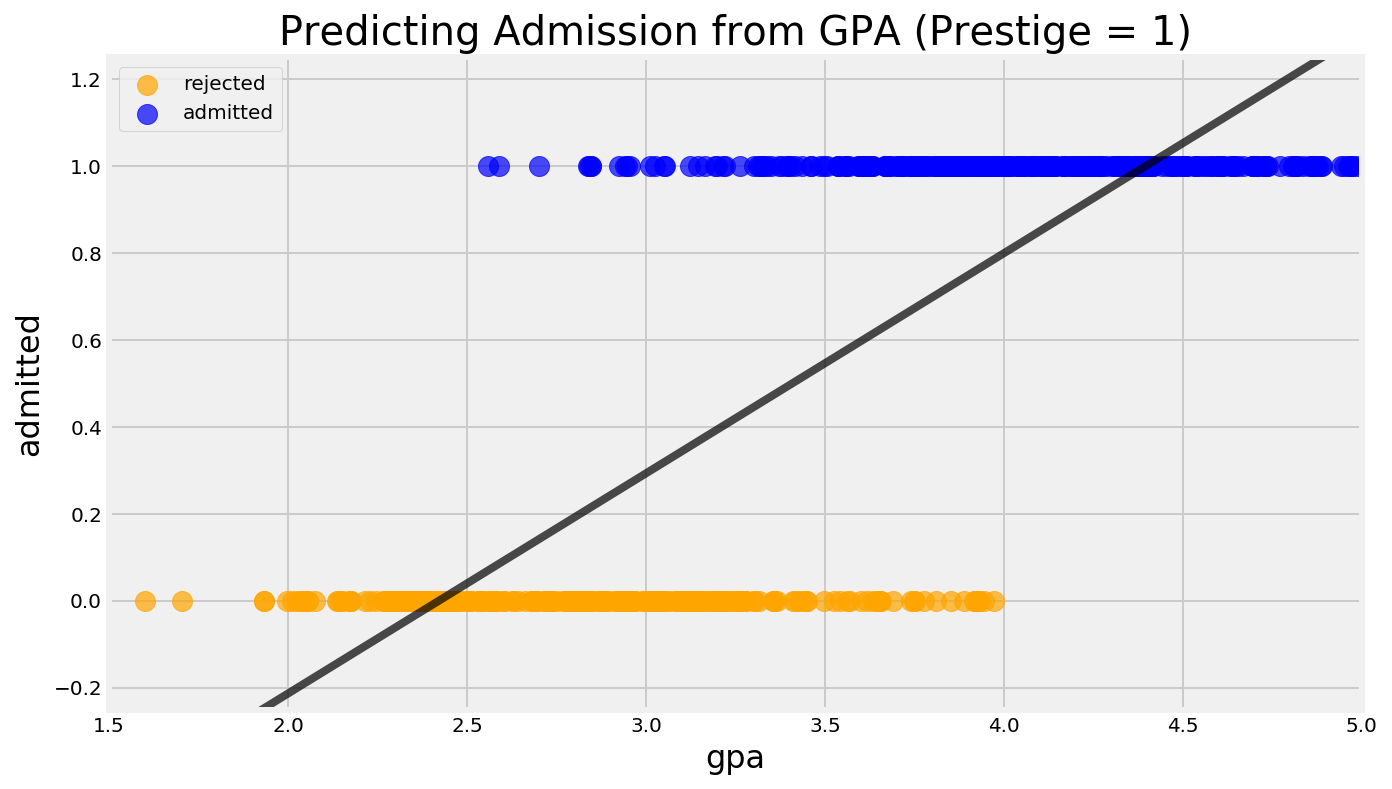

In [32]:
# Create figures.
fig, ax = plt.subplots(figsize=(10,6))

# Plot the regression line where gpa predicts admit.
x_vals = np.linspace(1, 5, 300)

# Plot line of best fit
ax.plot(x_vals,
        linmod.predict(x_vals[:, np.newaxis]),
        color='black', alpha=0.7, lw=4)

# Create scatterplot with orange dots for those rejected.
ax.scatter(admit['gpa'][admit['admit'] == 0],
           admit['admit'][admit['admit'] == 0],
           c='orange',
           s=100,
           alpha=0.7,
           label='rejected')

# Create scatterplot with blue dots for those admitted.
ax.scatter(admit['gpa'][admit['admit'] == 1],
           admit['admit'][admit['admit'] == 1],
           c='blue',
           s=100,
           alpha=0.7,
           label='admitted')

# Set labels of axis.
ax.set_ylabel('admitted', fontsize=16)
ax.set_xlabel('gpa', fontsize=16)
ax.set_title('Predicting Admission from GPA (Prestige = 1)', fontsize=20)

ax.set_xlim(1.5, 5)
ax.set_ylim(-0.25, 1.25)

plt.legend(loc='upper left')
plt.show()

# there is a significant overlap in gpa scores (from 2.5 to 4) btw those admitted, and those rejected. Not good.
# also, predictions values fall btw 0 and 1, but we just want 0 OR 1, nth in btw! 

#### **Note:** Unless we predict exactly one value, linear regression will always predict values between $-\infty$ and $+\infty$. There are real-world cases when this is inappropriate... because we may want to just make predictions on a smaller set or range of values.

<a id='pred-binary'></a>

## Predicting a Binary Class

---

In our case we have two classes: `1=admitted` and `0=rejected`.

The logistic regression is still solving for $\hat{Y}$. However, in our binary classification case, $\hat{Y}$ will be the probability of `y` being one of the classes.

### $$\hat{Y} = P(Y = 1)$$

We'll still try to fit a "line" of best fit to this... except it won't be perfectly linear. We need to *guarantee* that the right-hand side of the regression equation will evaluate to a probability. (That is, some number between 0 and 1!)

## The Logit Link Function (advanced)

---

We will use something called a **link function** to effectively "bend" our line of best fit so that it is a curve of best fit that matches the range or set of values in which we're interested.

For logistic regression, that specific link function that transforms ("bends") our line is known as the **logit** link.

### $$\text{logit}\left(P(Y = 1)\right) = \beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p$$

### $$\log\left(\frac{P(Y = 1)}{1 - P(Y = 1)}\right) = \beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p$$

Equivalently, we assume that each independent variable $X_i$ is linearly related to the **log of the odds of success**.

Remember, the purpose of the link function is to bend our line of best fit.
- This is convenient because we can have any values of $X$ inputs that we want, and we'll only ever predict between 0 and 1!
- However, interpreting a one-unit change gets a little harder. (More on this later.)

##### from the Ln (i think its Ln not Log) eqn, working it out, you'll eventually get p = (e^alpha)/(1+e^alpha), which lies btw 0 and 1! (where alpha = beta0 + beta1*x1 + beta2*x2 + beta3*x3...+ error)

<a id='logistic-viz'></a>

## Fitting and making predictions with the logistic regression model.

---

In [33]:
# Step 1: Instantiate our model.
logreg = LogisticRegression()

# Step 2: Fit our model.
logreg.fit(X_train, y_train)

print(f'Logistic Regression Intercept: {logreg.intercept_}')
print(f'Logistic Regression Coefficient: {logreg.coef_}')

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression Intercept: [-7.33666042]
Logistic Regression Coefficient: [[2.20134368]]


There are two methods in `sklearn` we will use **a lot** for the rest of this course and beyond:
- `.predict()`
- `.predict_proba()`

In [38]:
# Step 3 (part 1): Generate predicted values.
print(f'Logreg predicted values: {logreg.predict(X_test)}')

Logreg predicted values: [1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 1 0 0 0 1 1
 1 1 1 0 1 0 0 1 0 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 0 1 1 0 0 1 1 1 0 1
 0 0 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 1
 1 0 0 1 1 1 0 1 1 0 1 0 1 0 1 0 0 1 1 1 1 0 0 1 1 0 1 1 0 1 0 1 0 1 0 0 1
 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1
 1 1 0 0 1 1 0 0 0 0 1 0 1 0 0 0 1]


In [39]:
# Step 3 (part 2): Generate predicted probabilities.
print(f'Logreg predicted probabilities: {logreg.predict_proba(X_test)}')

# shows 1-p and p for each row.

Logreg predicted probabilities: [[0.05678415 0.94321585]
 [0.37785206 0.62214794]
 [0.19824978 0.80175022]
 [0.19053226 0.80946774]
 [0.12977766 0.87022234]
 [0.19907736 0.80092264]
 [0.09627616 0.90372384]
 [0.90465236 0.09534764]
 [0.10098792 0.89901208]
 [0.50890286 0.49109714]
 [0.23430061 0.76569939]
 [0.09382137 0.90617863]
 [0.7043681  0.2956319 ]
 [0.0458054  0.9541946 ]
 [0.85302851 0.14697149]
 [0.06939584 0.93060416]
 [0.1446878  0.8553122 ]
 [0.37444271 0.62555729]
 [0.60773689 0.39226311]
 [0.73729415 0.26270585]
 [0.74457769 0.25542231]
 [0.64634696 0.35365304]
 [0.76160408 0.23839592]
 [0.19262501 0.80737499]
 [0.88862795 0.11137205]
 [0.28913181 0.71086819]
 [0.80395603 0.19604397]
 [0.4962665  0.5037335 ]
 [0.18931443 0.81068557]
 [0.86140641 0.13859359]
 [0.97296182 0.02703818]
 [0.4356065  0.5643935 ]
 [0.90310089 0.09689911]
 [0.67996325 0.32003675]
 [0.67060805 0.32939195]
 [0.13805722 0.86194278]
 [0.21203403 0.78796597]
 [0.25087731 0.74912269]
 [0.33384076 0.666

<a id='log-odds'></a>

### Using the log-odds —the natural logarithm of the odds.

The combination of converting the "probability of success" to "odds of success," then taking the logarithm of that is called the **logit link function**.

### $$\text{logit}\big(P(Y=1)\big) = \log\bigg(\frac{P(Y=1)}{1-P(Y=1)}\bigg) = \beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p$$

We've bent our line how we want... but how do we interpret our coefficients?

---
<a id='odds-ratios'></a>
### Odds

Probabilities and odds represent the same thing in different ways. The odds for probability **p** is defined as:

### $$\text{odds}(p) = \frac{p}{1-p}$$

The odds of a probability is a measure of how many times as likely an event is to happen than it is to not happen.

**Example**: Suppose I'm looking at the probability and odds of a specific horse, "Secretariat," winning a race.

- When **`p = 0.5`**: **`odds = 1`**
    - The horse Secretariat is as likely to win as it is to lose.
- When **`p = 0.75`**: **`odds = 3`**
    - The horse Secretariat is three times as likely to win as it is to lose.
- When **`p = 0.40`**: **`odds = 0.666..`**
   - The horse Secretariat is two-thirds as likely to win as it is to lose.

In [50]:
# Define a function called odds to calculate the odds of success.
def odds(p):
    return p/(1-p)

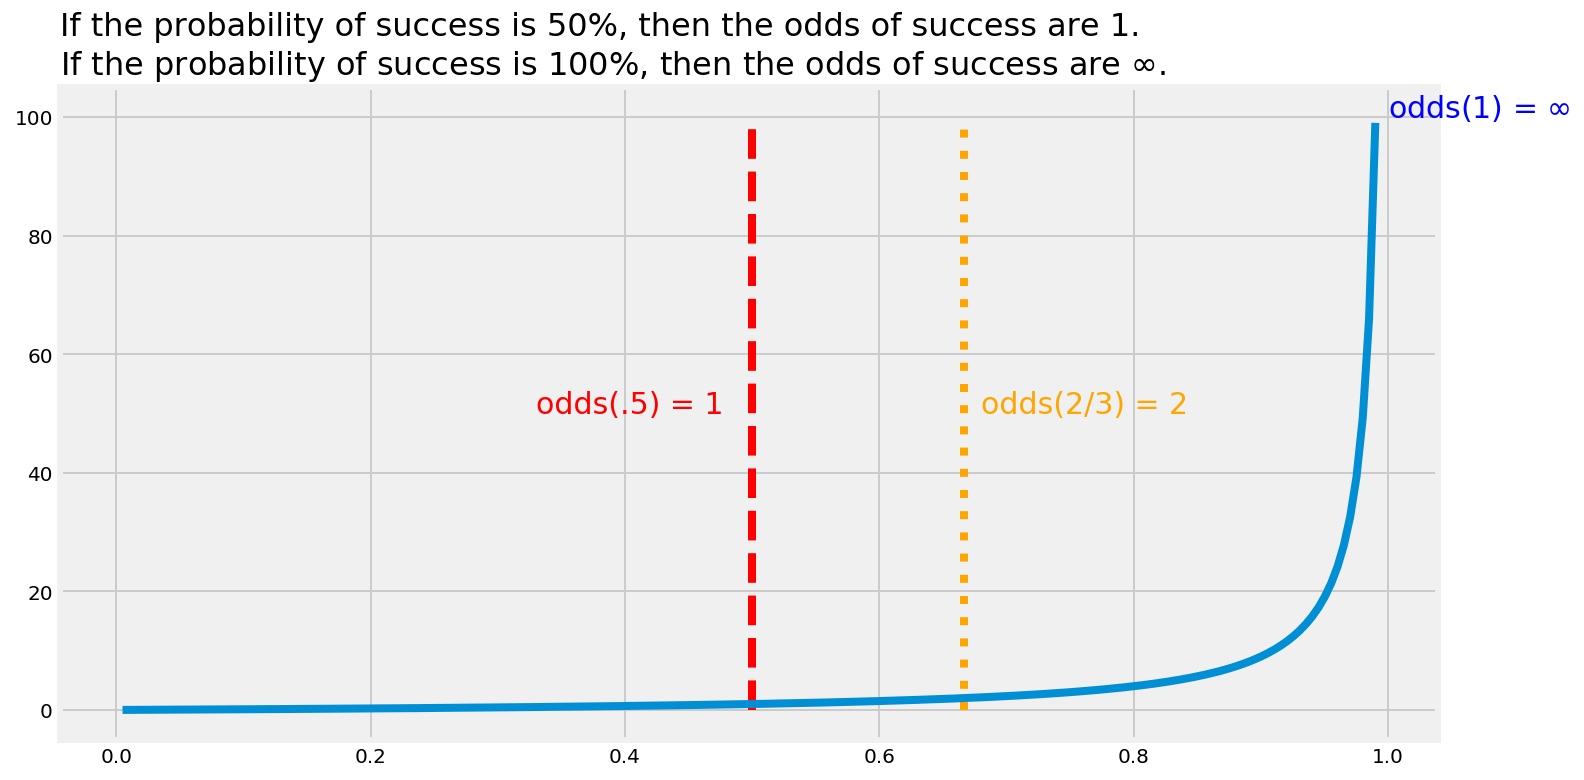

In [51]:
# Plot a range of probabilities.
probabilities = np.linspace(0.005, .99, 200)

# Generate list of odds.
odds_list = [odds(proba) for proba in probabilities]

# Create figure.
plt.figure(figsize=(11,6))

# Plot blue line for odds as probability goes from 0.5% to 99%.
plt.plot(probabilities,
         odds_list)

# Plot red dashed line to visualize odds when probability is 50%.
plt.vlines(.5, 0, 100, linestyles="dashed", color='red')
plt.text(.33, 50, "odds(.5) = 1", fontsize=15, color = 'red')

# Plot orange dotted line to visualize odds when probability is 66.67%.
plt.vlines(.6667, 0, 100, linestyles="dotted", color='orange')
plt.text(.68, 50, "odds(2/3) = 2", fontsize=15, color='orange')

# Annotate blue line when probability is 100%.
plt.text(1, 100, "odds(1) = $\infty$", fontsize=15, color='blue')

# Make title.
plt.title("If the probability of success is 50%, then the odds of success are 1.\nIf the probability of success is 100%, then the odds of success are $\infty$.",
          ha = 'left',
          position = (0,1),
          fontsize=16);

## Interpreting a one-unit change in $X_i$.

$$\log\bigg(\frac{P(Y=1)}{1-P(Y=1)}\bigg) = \beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p$$

Given this model, a one-unit change in $X_i$ implies a $\beta_i$ unit change in the log odds of success.

**This is annoying**.

We often convert log-odds back to "regular odds" when interpreting our coefficient... our mind understands odds better than the log of odds.

So, let's get rid of the log on the left-hand side. Mathematically, we do this by "exponentiating" each side.

$$
\begin{eqnarray*}
\log\bigg(\frac{P(Y=1)}{1-P(Y=1)}\bigg) &=& \beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p \\
\Rightarrow e^{\Bigg\{\log\bigg(\frac{P(Y=1)}{1-P(Y=1)}\bigg)\Bigg\}} &=& e^{\Bigg\{\beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p\Bigg\}} \\
\Rightarrow \exp{\Bigg\{\log\bigg(\frac{P(Y=1)}{1-P(Y=1)}\bigg)\Bigg\}} &=& \exp{\Bigg\{\beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p\Bigg\}} \\
\Rightarrow \frac{P(Y=1)}{1-P(Y=1)} &=& \exp{\Bigg\{\beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p\Bigg\}} \\
\end{eqnarray*}
$$

**Interpretation**: A one-unit change in $X_i$ means that success (or rather, odds) is $e^{\beta_i}$ times as likely.

<details><summary> I want to interpret the coefficient $\hat{\beta}_1$ for my logistic regression model. How would I interpret this coefficient?</summary>
    
- Our model is that $ln\bigg(\frac{P(admit=1)}{1-P(admit=1)}\bigg) = \beta_0 + \beta_1\text{GPA}$.
- As GPA increases by 1, the log-odds of someone being admitted increases by 2.20.
- As GPA increases by 1, someone is $e^{2.20}$ times as likely to be admitted.
- As GPA increases by 1, someone is about 9.04 times as likely to be admitted to grad school.
</details>

> Hint: Use the [np.exp](https://docs.scipy.org/doc/numpy/reference/generated/numpy.exp.html) function.

In [52]:
print(f'Logistic Regression Coefficient: {logreg.coef_}')

Logistic Regression Coefficient: [[2.20134368]]


In [53]:
# Use np.exp() to exponentiate the coefficient.
np.exp(logreg.coef_)

# hence, 1 unit increase in x1, will increase the ODDS (NOT p!!!) by 9x.
# just see the formula abv, where p/(1-p) = e^beta0 * e^(beta1*x1) * e^(beta2*x2)...
# hence when x1 increases from 1 to 2, p/(1-p) will be multiplied by e^beta1. so on so forth

array([[9.03714842]])

## Beyond binary classification problems.

Today, we looked at a binary classification problem: was somebody admitted, or not? Many of our classification problems will be binary. Even if the problem isn't binary, we can always force it to be binary. (i.e. Did the stock price increase or decrease?)

However, some of our classification problems won't be binary. You'll see an example of this in a later lesson!

<a id='conclusion'></a>

## Conclusion

---

The goal of logistic regression is to find the best-fitting model to describe the relationship between a binary outcome and a set of independent variables.

Logistic regression generates the coefficients of a formula to predict a logit transformation of the probability that the characteristic of interest is present.

**Benefits of logistic regression include:**
- It's a classification algorithm that shares similar properties to linear regression.
- It's efficient.
- It is by far the most common classification algorithm.
- The coefficients in a logistic regression model are interpretable (albeit somewhat complex); they represent the change in log-odds caused by the input variables.

<a id='solving-beta'></a>
## Solving For the Beta Coefficients (bonus)

---

Logistic regression minimizes the "deviance," which is similar to the residual sum of squares in linear regression, but is a more general form. 

**There's no closed-form solution to the beta coefficients like in linear regression, and the betas are found through optimization procedures.**
- We can't just do $\hat{\beta} = (X^TX)^{-1}X^Ty$ like we can in linear regression!

If you're particularly interested in the math, here are two helpful resources:
- [A good blog post](http://www.win-vector.com/blog/2011/09/the-simpler-derivation-of-logistic-regression/) on the logistic regression beta coefficient derivation.
- [This paper](https://www.stat.cmu.edu/~cshalizi/402/lectures/14-logistic-regression/lecture-14.pdf) is also a good reference.

<a id='logistic'></a>
## The Logistic Function (bonus)

---

The inverse function of the logit is called the **logistic function**. 

By inverting the logit, we can have the right side of our regression equation solve explicitly for $P(Y = 1)$:

### $$P(Y=1) = logit^{-1}\left(\beta_0 + \sum_{j}^p\beta_jX_j\right)$$

Where:

### $$logit^{-1}(a) = logistic(a) = \frac{e^{a}}{e^{a} + 1}$$ 

Giving us:

### $$P(Y=1) = \frac{e^{\left(\beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p\right)}}{e^{\left(\beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p\right)}+1}$$